In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})



In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from utils import (
    get_prepared_train_test,
    get_anomaly_detection_report,
    get_detection_score,
    get_best_score_threshold,
)

In [7]:
# Custom Dataset for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data  # TODO: preprocess

        # self.preprocess()
    
    def preprocess(self):
        raise NotImplementedError()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample, torch.tensor(0)

def get_dataloader(dataset, batch_size=64, shuffle=True):
    dataset = TabularDataset(dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [8]:
class BTCAddressAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [15]:
import torch
from torch import nn, optim
from tqdm import tqdm

def plot_losses(train_loss, val_loss):
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.plot(range(1, len(train_loss) + 1), train_loss, label="train")
    axs.plot(range(1, len(val_loss) + 1), val_loss, label="val")
    axs.set_ylabel('loss')

    axs.set_xlabel('epoch')

    plt.show()

def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-3, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # You can also try nn.SmoothL1Loss()

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch[0]
            batch = batch.to(device)
            optimizer.zero_grad()

            recon = model(batch)
            loss = criterion(recon, batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch[0]
                val_batch = val_batch.to(device)
                val_recon = model(val_batch)
                val_loss = criterion(val_recon, val_batch)
                total_val_loss += val_loss.item() * val_batch.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        plot_losses(train_losses, val_losses)

    print("✅ Training complete.")

def compute_reconstruction_errors(model, X_np, device='cuda'):
    model.eval()
    X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon = model(X_tensor)
        errors = torch.mean((X_tensor - recon) ** 2, axis=1)

    return errors.cpu().numpy()



**Prepare dataset**

In [13]:
wallets_feats = pd.read_csv("../dataset/custom/features_fixed/wallets_features_agg.csv")
wallets_feats.head()

,addrId,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,incoming_tx_cnt,incoming_tx_input_address_cnt_mean,incoming_tx_output_address_cnt_mean,btc_received_gini,input_address_cnt,...,outcoming_tx_fees_total,outcoming_tx_ts_cnt,outcoming_tx_ts_gini,incoming_tx_ts_cnt,incoming_tx_ts_gini,Time step,class,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,6.999303,6.999303,6.999303,6.999303,1.0,1.0,2.0,0.0,1.0,...,0.0010,1.0,0.0,1.0,0.0,1,3,391200.0,391200.0,0.0
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0001,1.0,0.0,0.0,0.0,1,3,391200.0,391200.0,0.0
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,0.390310,0.390310,0.390310,0.390310,1.0,4.0,2.0,0.0,4.0,...,0.0001,1.0,0.0,1.0,0.0,1,3,391200.0,399271.0,8071.0
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0001,1.0,0.0,0.0,0.0,1,3,391200.0,391200.0,0.0
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,3.200299,3.200299,3.200299,3.200299,1.0,1.0,2.0,0.0,1.0,...,0.0001,1.0,0.0,1.0,0.0,1,3,391200.0,391200.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def transform_dataset(df_raw, scaler, tp="licit"):
    if tp == "all":
        df = df_raw
    if tp == "illicit":
        df = df_raw[df_raw["class"] == 1]
    if tp == "licit":
        df = df_raw[df_raw["class"] == 2]
    if tp == "unknown":
        df = df_raw[df_raw["class"] == 3]
    if tp == "no_illicit":
        df = df_raw[df_raw["class"] != 1]
    df = df.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ])
    scaler = StandardScaler()
    df_transformed = scaler.fit_transform(df)

    return df_transformed

In [124]:
scaler = StandardScaler()
scaler.fit(wallets_feats.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

dataset_transformed = transform_dataset(wallets_feats, scaler, tp="licit")
dataset_fraud_transformed = transform_dataset(wallets_feats, scaler, tp="illicit")
dataset_unk_transformed = transform_dataset(wallets_feats, scaler, tp="unknown")

dataset_train, dataset_val = train_test_split(
    dataset_transformed,
    test_size=0.15
)
train_loader = get_dataloader(dataset_train)
val_loader = get_dataloader(dataset_val)

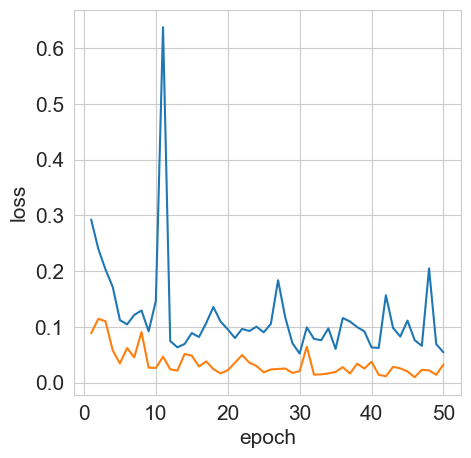

✅ Training complete.


In [47]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu"
)

In [19]:
def get_licit_illicit_recon_errors(
        model,
        licit_dataset,
        illicit_dataset,
        unk_dataset=None,
        cnt=20,
        plot=False
):
    licit_idxs = np.random.choice(licit_dataset.shape[0], cnt if cnt is not None else licit_dataset.shape[0], replace=False)
    illicit_idxs = np.random.choice(illicit_dataset.shape[0], cnt if cnt is not None else illicit_dataset.shape[0], replace=False)
    licit_errs = compute_reconstruction_errors(
        model,
        licit_dataset[licit_idxs],
        device="cpu"
    )
    illicit_errs = compute_reconstruction_errors(
        model,
        illicit_dataset[illicit_idxs],
        device="cpu"
    )

    if unk_dataset is not None:
        unk_idxs = np.random.choice(unk_dataset.shape[0], cnt if cnt is not None else unk_dataset.shape[0], replace=False)
        unk_errs = compute_reconstruction_errors(
            model,
            unk_dataset[unk_idxs],
            device="cpu"
        )

    if plot:
        # sns.histplot(licit_errs[licit_errs<np.quantile(licit_errs, 0.95)], label="Licit", bins=30)
        # sns.histplot(illicit_errs[illicit_errs<np.quantile(illicit_errs, 0.95)], label="Illicit", bins=30)

        sns.histplot(licit_errs[licit_errs<0.8], label="Licit", bins=30)
        sns.histplot(illicit_errs[illicit_errs<0.8], label="Illicit", bins=30)
        
        if unk_dataset is not None:
            sns.histplot(unk_errs[unk_errs<0.8], label="Unknown", bins=30, alpha=0.5)
        plt.legend()
        
    return licit_errs, illicit_errs

(array([0.00678498, 0.00122546, 0.00220972, ..., 0.00610104, 0.00152789,
        0.00242372], dtype=float32),
 array([0.03785777, 0.03651204, 1.1389788 , ..., 0.09837189, 0.01988318,
        0.02599768], dtype=float32))

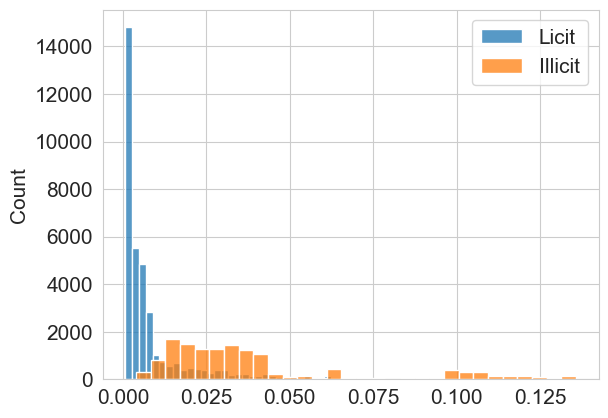

In [126]:
get_licit_illicit_recon_errors(
    autoencoder,
    dataset_val,
    dataset_fraud_transformed,
    cnt=None,
    plot=True
)

(array([0.03318103, 0.00821541, 0.00301206, ..., 0.00141369, 0.00229823,
        0.00821541], dtype=float32),
 array([0.03661707, 0.0270613 , 0.0629928 , ..., 1.4317366 , 0.02871591,
        0.01429698], dtype=float32))

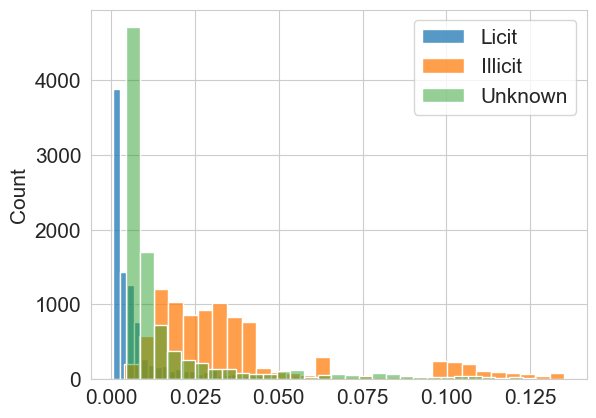

In [134]:
get_licit_illicit_recon_errors(
    autoencoder,
    dataset_val,
    dataset_fraud_transformed,
    dataset_unk_transformed,
    cnt=10000,
    plot=True
)

### **Train on separate splits (licit only)**

In [174]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__test.csv")

scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="licit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

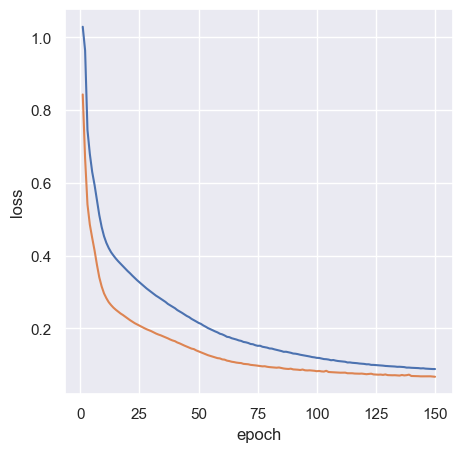

✅ Training complete.


In [192]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=150
)

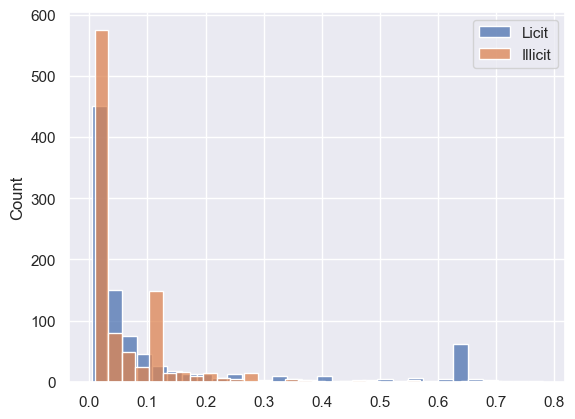

In [193]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

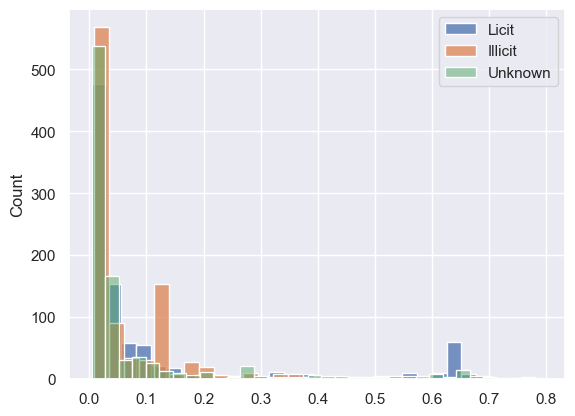

In [194]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    test_data[test_labels == 3],
    cnt=1000,
    plot=True,
)

In [195]:
test_data[test_labels == 1].shape

(2721, 33)

In [173]:
test_data.shape

(646229, 33)

In [196]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")


	real 1	real 0
pred 1	1146	61230	
pred 0	1575	121076	
[0.014705961832597404, 0.014922343466262885, 0.017212069698257542, 0.01724416713431047, 0.01644404031607392, 0.01673313681290099, 0.017865472525422147, 0.018963106020245073, 0.016219588271990017, 0.01645023283988945, 0.01633187943747922, 0.017014598690867043, 0.017105720744218397, 0.016932449381831215, 0.01692573402417962, 0.017357624444125662, 0.008476676746145839, 0.00823585882828487, 0.007684346701164295, 0.007639641544846546, 0.007796158965582811, 0.00777000777000777, 0.007758061331001213, 0.006743242470998343, 0.006759294029290274, 0.0065369056692267105, 0.006221435942798172, 0.00623545557610836, 0.0056753688989784334, 0.005616417219564882, 0.005377520712834141, 0.0052786294528558335, 0.005154971325472002, 0.0051343710395476555, 0.00508146739664951, 0.005037866315442871, 0.005075805327936834, 0.004959680296867195, 0.004435789245915828, 0.004416703168345744]


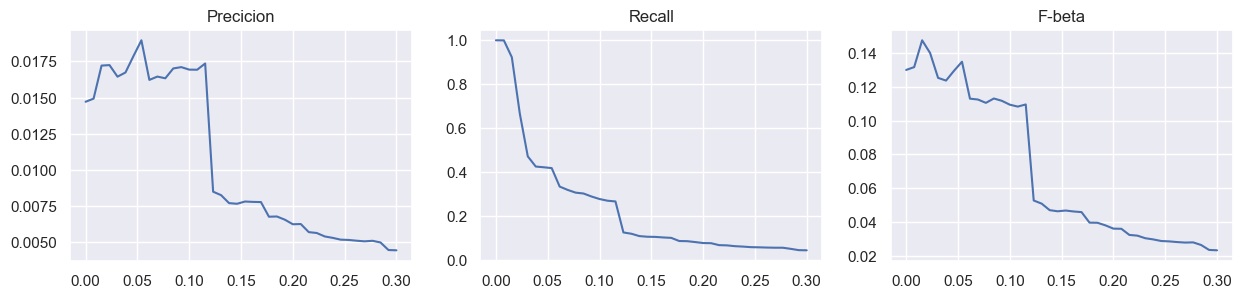

In [199]:
get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)

	real 1	real 0
pred 1	1146	24815	
pred 0	1575	34581	
[0.043804433568910284, 0.04501969611705121, 0.05133814479360471, 0.047817486482922326, 0.03946276546700679, 0.04029928658430486, 0.04288753685939308, 0.04639511201629328, 0.04036192672757917, 0.04125913968284114, 0.04129370456456159, 0.04513584574934268, 0.04419858474671459, 0.04409963250306247, 0.04436798261499457, 0.04570349386213409, 0.022721233058729737, 0.02209270805096232, 0.02055221091965954, 0.020287820287820287, 0.020387866732968673, 0.02015403440581588, 0.0201894134057705, 0.01767260745843942, 0.01761782864026502, 0.017109099278809266, 0.016293436293436294, 0.01634600344126388, 0.014743385400063756, 0.01455534229046705, 0.014083353803324327, 0.013924789460518635, 0.013596193065941536, 0.013536668951336532, 0.013443191673894189, 0.013321723987810187, 0.013384655760650862, 0.012271563520791031, 0.01092265340555901, 0.010869565217391304]


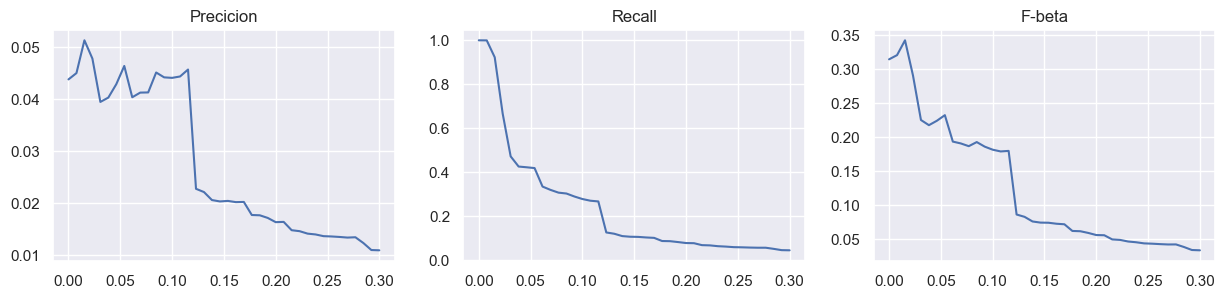

In [200]:
get_best_score_threshold(
    licit_scores,
    illicit_scores,
    np.array([]),
    plot=True,
    thr_interval=(0,0.3)
)

### **Train on separate splits (licit + unknown)**

In [203]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features__test.csv")

scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

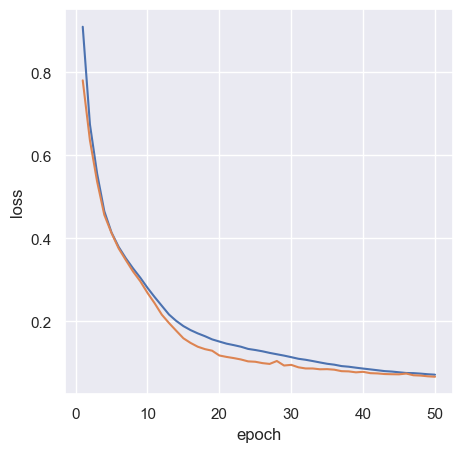

Training: 100%|██████████| 50/50 [05:51<00:00,  7.03s/it]

✅ Training complete.


In [207]:
autoencoder = BTCAddressAutoencoder(input_dim=33)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

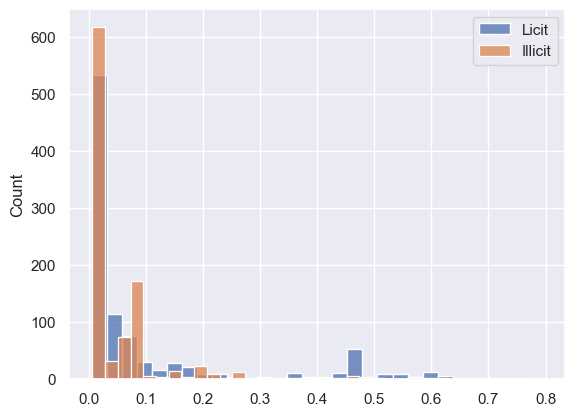

In [211]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	969	51167	
pred 0	1752	131139	
[0.014705961832597404, 0.015067587463678336, 0.014319847340485239, 0.014136255260380702, 0.015854018682872995, 0.016940990316977107, 0.018110221594813975, 0.018652910717087714, 0.016879068682542037, 0.017314675405189973, 0.017046896265368733, 0.007526439340771037, 0.007474772642332129, 0.0074034362155676395, 0.007516820857863751, 0.0075495944100875435, 0.007930600091617042, 0.008135715792328321, 0.008190872141726908, 0.00753021578181358, 0.007362160424369072, 0.007312434417628542, 0.007399013464871351, 0.00739190603166031, 0.007636016544702514, 0.007671625739379817, 0.006088890509352098, 0.0058024237972824095, 0.005007046954973666, 0.0046920160654630085, 0.004652049571020019, 0.004568706314186419, 0.0046128762874299125, 0.004594180704441042, 0.0040219378427787935, 0.003457216940363008, 0.0034037607405255073, 0.0034453781512605044, 0.003435405886843668, 0.003375491368996753]


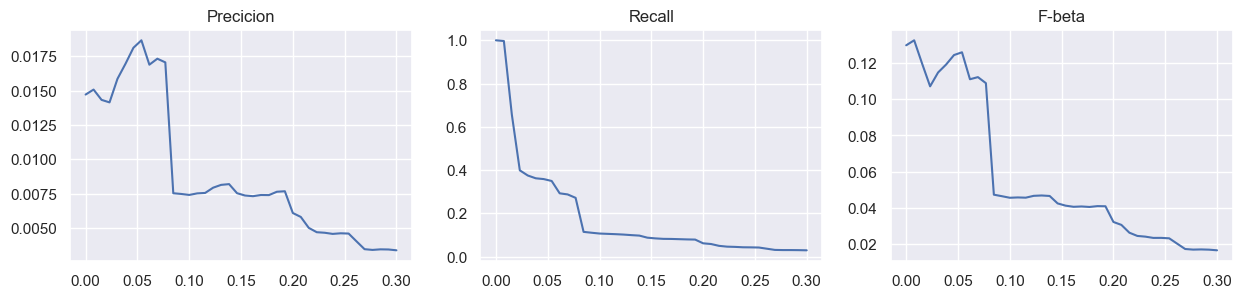

In [213]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)


### **On new dataset**

In [5]:
pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv").columns

Index(['addrId', 'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'incoming_tx_cnt',
       'incoming_tx_input_address_cnt_mean',
       'incoming_tx_output_address_cnt_mean', 'btc_received_gini',
       'input_address_cnt', 'incoming_tx_fees_mean', 'incoming_tx_fees_min',
       'incoming_tx_fees_max', 'incoming_tx_whole_fee_4_cnt', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'outcoming_tx_cnt',
       'outcoming_tx_output_address_cnt_mean',
       'outcoming_tx_input_address_cnt_mean', 'btc_sent_gini',
       'output_address_cnt', 'outcoming_tx_fees_mean', 'outcoming_tx_fees_min',
       'outcoming_tx_fees_max', 'outcoming_tx_whole_fee_4_cnt',
       'outcoming_tx_fees_total', 'outcoming_tx_ts_cnt',
       'outcoming_tx_ts_gini', 'incoming_tx_ts_cnt', 'incoming_tx_ts_gini',
       'Time step', 'class', 'first_block_appeared_in',
       'last_block_appeared_in', 'lifetime_in_blocks', 'userId',
       'user_addr_cnt

In [12]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

train_data_full = train_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])
test_data_full = test_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])


scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

In [13]:
train_data.shape

(461184, 35)

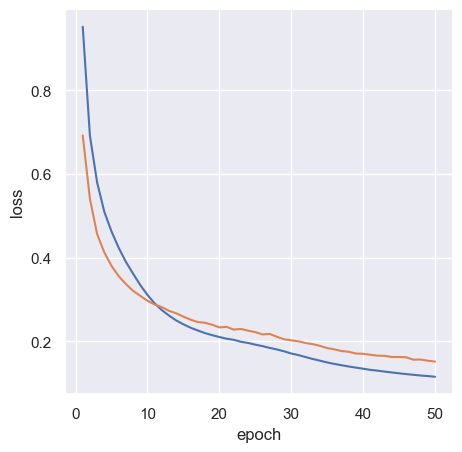

Training: 100%|██████████| 50/50 [05:09<00:00,  6.19s/it]

✅ Training complete.


In [17]:
autoencoder = BTCAddressAutoencoder(input_dim=35)
train_autoencoder(
    autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cpu",
    lr=0.00001,
    num_epochs=50
)

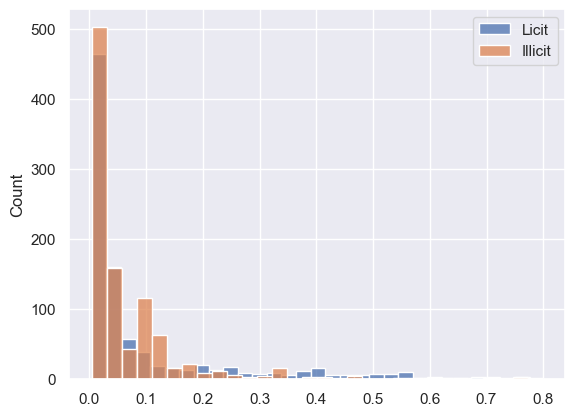

In [20]:
_ = get_licit_illicit_recon_errors(
    autoencoder,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    cnt=1000,
    plot=True,
)

	real 1	real 0
pred 1	2016	96936	
pred 0	2489	179593	
[0.01603008888604226, 0.016489614713810052, 0.020929688394577397, 0.018512129251781615, 0.018255941946267683, 0.01964609923312468, 0.020773253824722615, 0.016634437444118688, 0.01690715798205593, 0.01639720215571609, 0.016054557078923067, 0.016218894649698463, 0.013142835582498019, 0.010723192019950124, 0.0108226269345278, 0.007423884711437422, 0.007207232228409548, 0.007246478972522593, 0.007132972880437108, 0.007029902451044339, 0.006995570938315783, 0.006587146163432437, 0.006062931696085955, 0.006062625974067197, 0.005820453798092732, 0.005557117576038238, 0.005538636591814196, 0.005511193011193011, 0.005401342469584673, 0.005272218635678933, 0.005312157721796276, 0.005341982256987504, 0.005188400078911028, 0.005134967731623009, 0.005141962888441762, 0.005110872970076663, 0.005118984664198837, 0.005158960469465403, 0.005099573570141117, 0.005006867827551066]


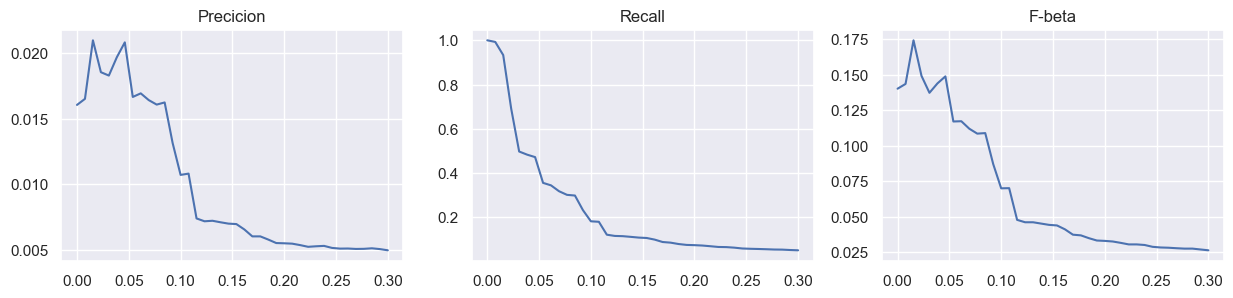

In [21]:
licit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(autoencoder, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0,0.3)
)


In [22]:
(2016+179593) / (2016+179593+2489+96936)

0.6462171836859597